## Importing Libraries and Loading Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import os
import h5py

In [2]:
data = pd.read_csv("dataset.csv")
print(data.head()) 

                       IMAGE     mfcc_1     mfcc_2     mfcc_3     mfcc_4  \
0  images/forest/forest0.png  15.795384  -3.442518 -25.316836 -33.412104   
1  images/forest/forest1.png  15.883880  -3.494075 -21.189490 -18.077115   
2  images/forest/forest2.png  17.872629 -18.877467 -31.665319 -47.045579   
3  images/forest/forest3.png  16.843997  -3.527753 -21.282970 -24.248141   
4  images/forest/forest4.png  16.128583  -4.267328 -25.608325 -20.231084   

      mfcc_5     mfcc_6     mfcc_7     mfcc_8     mfcc_9  ...    mfcc_97  \
0   2.447290 -46.981182  12.889984 -23.588534 -22.625879  ... -43.876462   
1   4.284962 -27.014271   3.666955  -9.091312  -3.746509  ... -33.883092   
2   1.813430 -45.899877  14.975982 -24.462396  -1.812962  ... -34.456028   
3  27.201589 -18.787674  30.093938  -1.922008  10.156418  ... -36.410615   
4  15.922823 -35.703313  16.307644  -3.547505   4.804142  ... -41.548915   

     mfcc_98    mfcc_99   mfcc_100   mfcc_101   mfcc_102   mfcc_103  \
0  20.697491 -2

### Visualizing CLASS1 and CLASS2 Distribution with Pie Charts

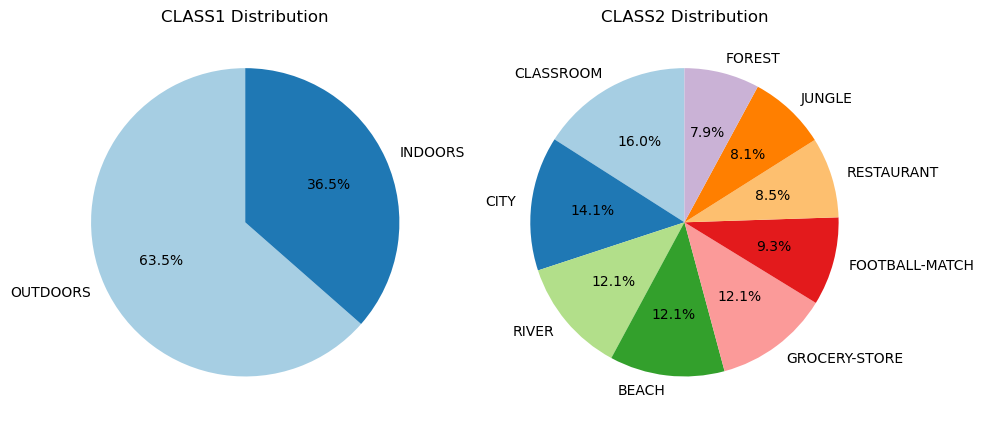

In [3]:
plt.figure(figsize=(10, 5))

# CLASS1 Distribution
plt.subplot(1, 2, 1)
class1_counts = data['CLASS1'].value_counts()
plt.pie(class1_counts, labels=class1_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('CLASS1 Distribution')

# CLASS2 Distribution
plt.subplot(1, 2, 2)
class2_counts = data['CLASS2'].value_counts()
plt.pie(class2_counts, labels=class2_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('CLASS2 Distribution')

plt.tight_layout()
plt.show()

CLASS1: Outdoors (63.5%) dominates over Indoors (36.5%), indicating a slight class imbalance.
CLASS2: Categories are more balanced, with Classroom (16%) as the largest and Forest (7.9%) as the smallest class.

### Preparing Data and Features for Audio and Images

In [4]:
data['CLASS1'] = data['CLASS1'].astype('category').cat.codes
data['CLASS2'] = data['CLASS2'].astype('category').cat.codes

In [5]:
mfcc_columns = [col for col in data.columns if 'mfcc' in col]
audio_features = data[mfcc_columns].replace('[^.0-9-]', '', regex=True).astype(float).values
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [6]:
scaler = StandardScaler()
audio_features_scaled = scaler.fit_transform(audio_features)

### Training and Evaluating Model with ROC Curve Visualization

In [7]:
def train_and_evaluate_with_roc(X, y, label):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')  
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print(f"{label} Accuracy:", accuracy_score(y_test, y_pred))
    print(f"{label} Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    
    if hasattr(model, "predict_proba") and len(np.unique(y)) == 2: 
        y_score = model.predict_proba(X_test)[:, 1] 
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--")
        plt.plot(fpr, tpr, color="orange", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
        plt.title(f'ROC Curve for {label}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print(f"Model {type(model).__name__} does not support probability prediction.")


### Visualizing Feature Clusters with t-SNE Plot

In [8]:
def plot_tsne(features, labels, title):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_results = tsne.fit_transform(features)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.title(title)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.colorbar(label='Class')
    plt.show()

Due to the nature of this dataset, where machine learning is based on audio and image features transformed into numerical values, these features become hard for humans to interpret. Thus, for visualizing patterns and separations based on training categories, t-SNE is the most suitable method.

# Sound

Audio CLASS1 (Outdoors/Indoors) Accuracy: 0.7652854245146334
Audio CLASS1 (Outdoors/Indoors) Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.75      0.70      1240
           1       0.85      0.78      0.81      2211

    accuracy                           0.77      3451
   macro avg       0.75      0.76      0.75      3451
weighted avg       0.78      0.77      0.77      3451



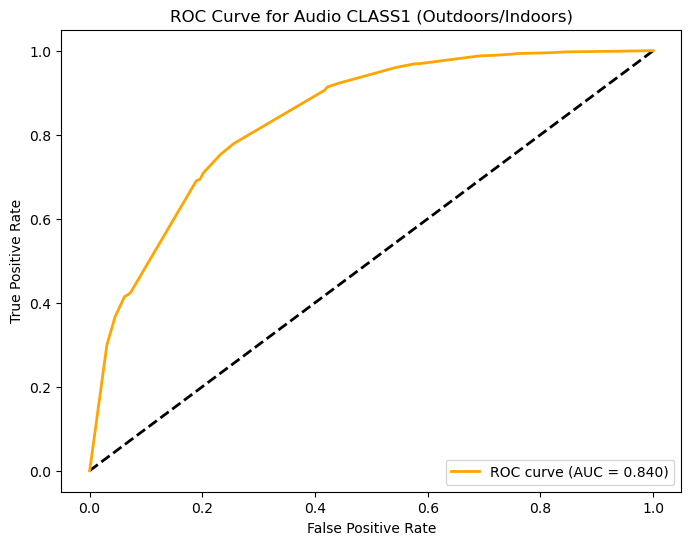

Audio CLASS2 (FOREST, CITY, etc.) Accuracy: 0.46769052448565634
Audio CLASS2 (FOREST, CITY, etc.) Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.68      0.47       404
           1       0.25      0.06      0.10       500
           2       0.57      0.61      0.59       527
           3       0.77      0.63      0.69       334
           4       0.53      0.68      0.60       271
           5       0.70      0.11      0.19       407
           6       0.88      0.87      0.87       275
           7       0.71      0.19      0.30       306
           8       0.26      0.59      0.36       427

    accuracy                           0.47      3451
   macro avg       0.56      0.49      0.46      3451
weighted avg       0.53      0.47      0.44      3451

Model DecisionTreeClassifier does not support probability prediction.


In [9]:
train_and_evaluate_with_roc(audio_features_scaled, data['CLASS1'], "Audio CLASS1 (Outdoors/Indoors)")
train_and_evaluate_with_roc(audio_features_scaled, data['CLASS2'], "Audio CLASS2 (FOREST, CITY, etc.)")

### t-SNE Visualization for Audio Features

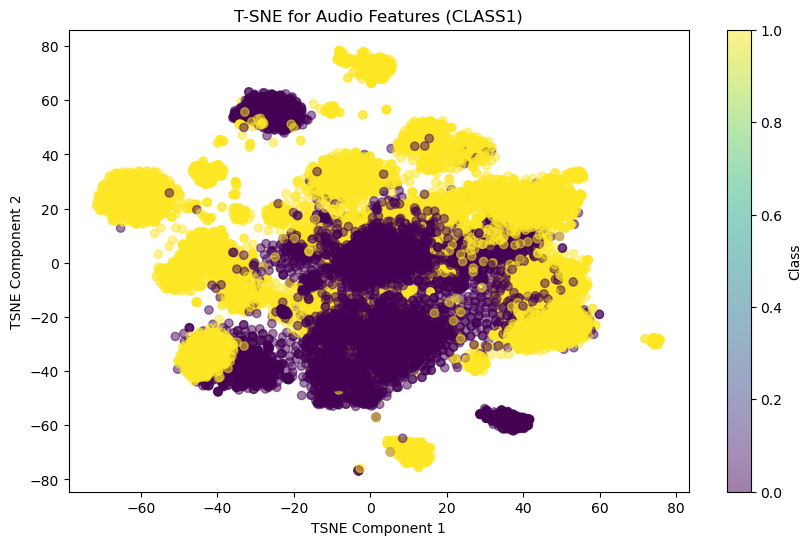

In [10]:
plot_tsne(audio_features_scaled, data['CLASS1'], "T-SNE for Audio Features (CLASS1)")

The t-SNE visualization shows clusters for Outdoors and Indoors classes with some overlap. The pink and yellow clusters indicate areas where audio features (e.g., MFCC) provide separability.

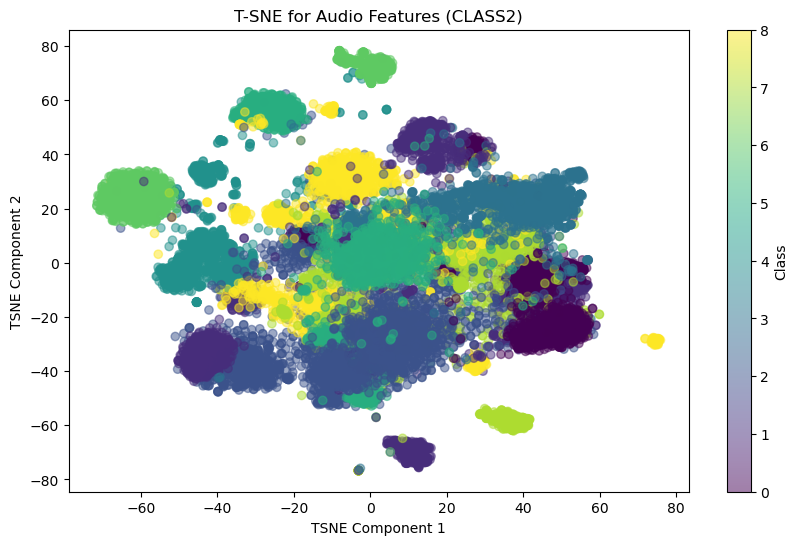

In [11]:
plot_tsne(audio_features_scaled, data['CLASS2'], "T-SNE for Audio Features (CLASS2)")

The t-SNE visualization for CLASS2 shows multiple clusters corresponding to different categories (e.g., Forest, City). While some clusters are distinct, others overlap, indicating shared audio features between certain environments.

# Images

### Extracting Image Features in Batches Using VGG16

In [12]:
def extract_image_features_batch(image_paths, batch_size=32):
    features = []
    batch_images = []
    for i, path in enumerate(image_paths):
        if os.path.exists(path):
            img = load_img(path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            batch_images.append(img_array)
        else:
            features.append(np.zeros((7 * 7 * 512,)))
        
        if len(batch_images) == batch_size or i == len(image_paths) - 1:
            batch_images_array = np.array(batch_images)
            batch_features = vgg_model.predict(batch_images_array)
            features.extend(batch_features.reshape(batch_features.shape[0], -1))
            batch_images = []
    
    return np.array(features)

### Saving and Loading Extracted Image Features Using HDF5

In [13]:
features_file = "image_features.h5"

if not os.path.exists(features_file):
    print("Extracting features...")
    image_features = extract_image_features_batch(data['IMAGE'], batch_size=32)
    
    with h5py.File(features_file, 'w') as hf:
        hf.create_dataset('features', data=image_features, dtype='float32')
    print(f"The features are saved in {features_file}")
else:
    print("Loading saved features in chunks...")
    chunk_size = 1000 
    image_features = []

    with h5py.File(features_file, 'r') as hf:
        dataset = hf['features']
        for i in range(0, dataset.shape[0], chunk_size):
            image_features.append(dataset[i:i + chunk_size])

    image_features = np.vstack(image_features)
    print("Features loaded successfully.")

Loading saved features in chunks...
Features loaded successfully.


Image CLASS1 (Outdoors/Indoors) Accuracy: 0.8948130976528542
Image CLASS1 (Outdoors/Indoors) Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1240
           1       0.94      0.90      0.92      2211

    accuracy                           0.89      3451
   macro avg       0.88      0.89      0.89      3451
weighted avg       0.90      0.89      0.90      3451



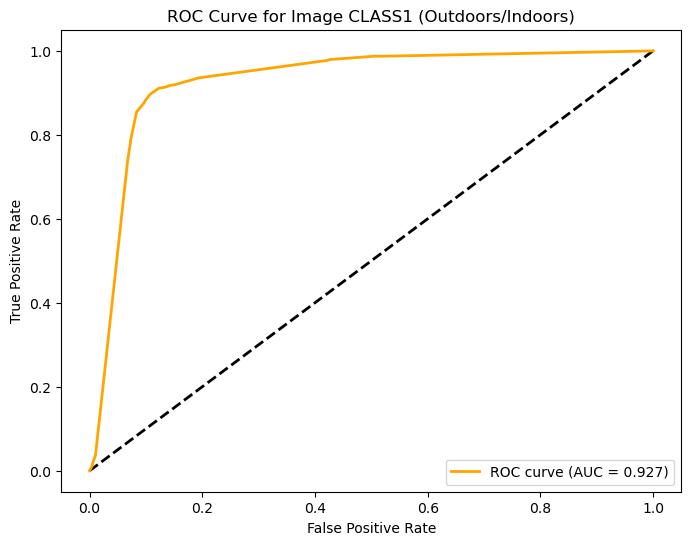

Image CLASS2 (FOREST, CITY, etc.) Accuracy: 0.5882352941176471
Image CLASS2 (FOREST, CITY, etc.) Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92       404
           1       0.71      0.55      0.62       500
           2       0.95      0.70      0.81       527
           3       0.57      0.55      0.56       334
           4       0.84      0.73      0.78       271
           5       0.00      0.00      0.00       407
           6       0.65      0.72      0.69       275
           7       0.21      0.84      0.33       306
           8       0.94      0.45      0.61       427

    accuracy                           0.59      3451
   macro avg       0.65      0.60      0.59      3451
weighted avg       0.67      0.59      0.60      3451

Model DecisionTreeClassifier does not support probability prediction.


In [14]:
image_features_scaled = scaler.fit_transform(image_features)    

train_and_evaluate_with_roc(image_features_scaled, data['CLASS1'], "Image CLASS1 (Outdoors/Indoors)")
train_and_evaluate_with_roc(image_features_scaled, data['CLASS2'], "Image CLASS2 (FOREST, CITY, etc.)")

### t-SNE Visualization for Image Features

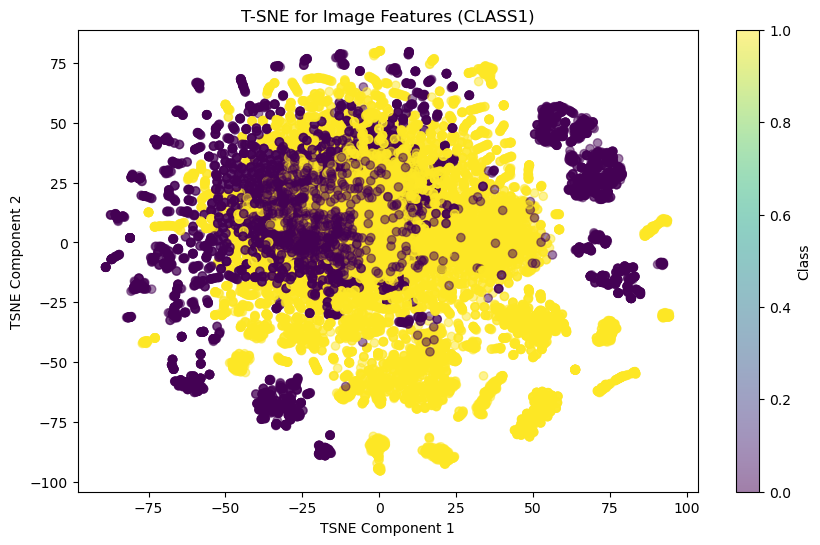

In [15]:
plot_tsne(image_features_scaled, data['CLASS1'], "T-SNE for Image Features (CLASS1)")

The t-SNE visualization for CLASS1 (Image Features) shows two main clusters representing Outdoors and Indoors classes. There is notable overlap between the clusters, indicating some shared visual features between the two environments.

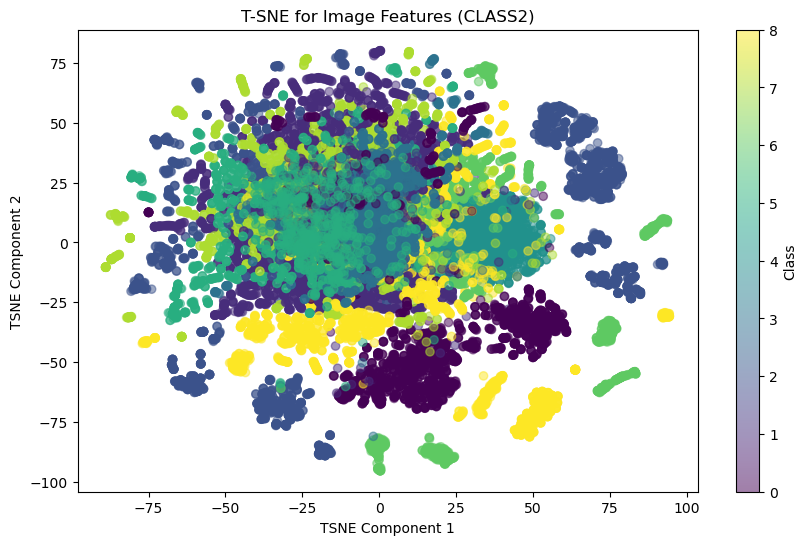

In [16]:
plot_tsne(image_features_scaled, data['CLASS2'], "T-SNE for Image Features (CLASS2)")

The t-SNE visualization for CLASS2 (Image Features) shows overlapping clusters for several categories, reflecting shared visual patterns. While some distinct clusters are visible (e.g., certain environments like "Beach" or "City"), the majority of classes exhibit significant overlap, suggesting that image features alone may not be sufficient to fully differentiate all categories.

# Multimodal ML with Audio and Images Combined

In [17]:
combined_features = np.hstack([image_features, audio_features])
combined_features_scaled = np.hstack([image_features_scaled, audio_features_scaled])

Combined CLASS1 (Outdoors/Indoors) Accuracy: 0.8991596638655462
Combined CLASS1 (Outdoors/Indoors) Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.86      1240
           1       0.94      0.90      0.92      2211

    accuracy                           0.90      3451
   macro avg       0.89      0.90      0.89      3451
weighted avg       0.90      0.90      0.90      3451



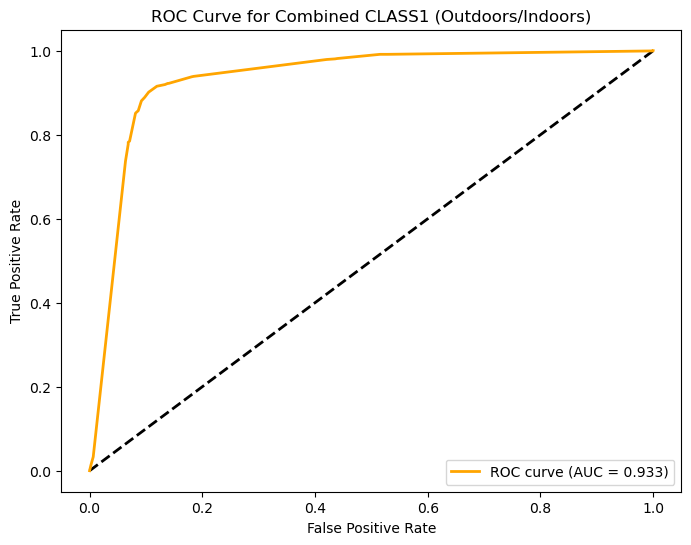

Combined CLASS2 (FOREST, CITY, etc.) Accuracy: 0.592292089249493
Combined CLASS2 (FOREST, CITY, etc.) Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93       404
           1       0.71      0.55      0.62       500
           2       0.96      0.70      0.81       527
           3       0.72      0.60      0.65       334
           4       0.74      0.69      0.72       271
           5       0.00      0.00      0.00       407
           6       0.62      0.70      0.66       275
           7       0.21      0.84      0.33       306
           8       0.92      0.47      0.62       427

    accuracy                           0.59      3451
   macro avg       0.65      0.61      0.59      3451
weighted avg       0.67      0.59      0.60      3451

Model DecisionTreeClassifier does not support probability prediction.


In [18]:
train_and_evaluate_with_roc(combined_features_scaled, data['CLASS1'], "Combined CLASS1 (Outdoors/Indoors)")
train_and_evaluate_with_roc(combined_features_scaled, data['CLASS2'], "Combined CLASS2 (FOREST, CITY, etc.)")

Сonfusion Matrix for Combined CLASS1 (Outdoors/Indoors) shows strong overall accuracy with minimal confusion.

Confusion Matrix for Combined CLASS2 (FOREST, CITY, etc.):
Some smaller classes, like Jungle, are more prone to confusion due to limited separability in features.

### t-SNE Visualization for Combined Features

In [19]:
combined_features_scaled = np.hstack([image_features_scaled, audio_features_scaled])

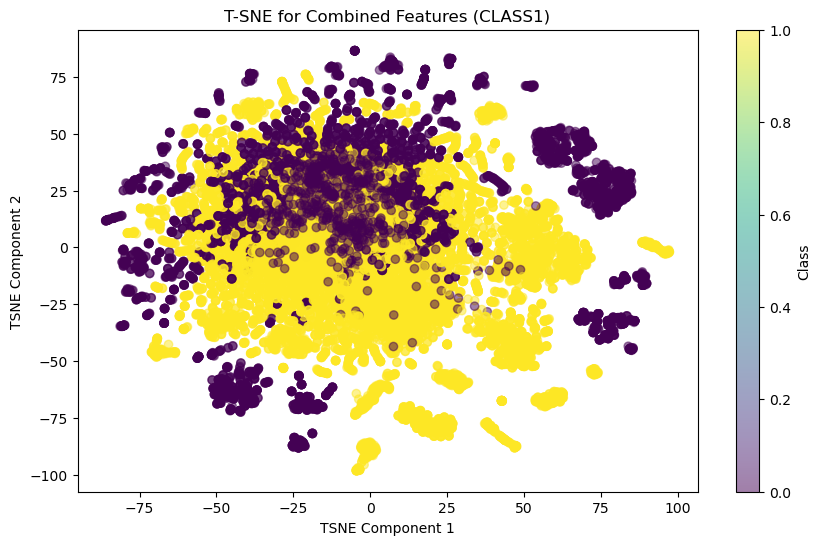

In [20]:
plot_tsne(combined_features_scaled, data['CLASS1'], "T-SNE for Combined Features (CLASS1)")

The t-SNE visualization for CLASS1 (Combined Features) shows improved clustering compared to individual audio or image features. The combination of features leads to clearer separability of the Outdoors and Indoors classes, although some overlap remains, indicating shared characteristics between these categories.

In [ ]:
plot_tsne(combined_features_scaled, data['CLASS2'], "T-SNE for Combined Features (CLASS2)")

The t-SNE visualization for CLASS2 (Combined Features) shows improved cluster separability compared to individual features. While overlap still exists among some categories (e.g., Jungle and Forest), the combination of audio and image features provides better differentiation between classes such as City and Classroom, highlighting the benefit of multimodal data.